In [27]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

print(spark.version)

3.5.4


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [31]:
df_2018 = spark.read.csv(f"C:/Users/gyalm/OneDrive/Desktop/churn_prediction/churn_prediction/data/week2_data_for_student_lab.csv.gz", inferSchema=True, header=True)
df_2018.show(10)
df_2018.createOrReplaceTempView("df_2018_view")

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [4]:
spark.sql('''SELECT * FROM df_2018_view LIMIT 5''').show()

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [5]:
spark.sql('''
WITH customer_base AS (
    SELECT DISTINCT member_id
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
),
customer_base_joined_with_past_3_months_txn AS (
    SELECT 
        a.member_id,
        b.quantity,
        b.transaction_date
    FROM customer_base AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
),
customer_base_with_aggregated_total_txns_per_month AS (
    SELECT 
        member_id,
        SUM(
            CASE 
                WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' 
                THEN quantity 
                ELSE 0 
            END
        ) AS sum_quantity,
        '2018-06-01' AS partition_month
    FROM customer_base_joined_with_past_3_months_txn
    GROUP BY member_id
),
customers_with_target_definition AS (
    SELECT 
        *,
        CASE 
            WHEN sum_quantity = 0 THEN 1 
            ELSE 0 
        END AS target
    FROM customer_base_with_aggregated_total_txns_per_month
),
count_customers_with_target_definition AS (
    SELECT 
        target,
        COUNT(member_id) AS cnt_member_id,
        COUNT(DISTINCT member_id) AS cntd_member_id
    FROM customers_with_target_definition
    GROUP BY target
)

SELECT * 
FROM count_customers_with_target_definition
''').show()


+------+-------------+--------------+
|target|cnt_member_id|cntd_member_id|
+------+-------------+--------------+
|     1|        15873|         15873|
|     0|        34794|         34794|
+------+-------------+--------------+



In [4]:
# Show first 5 rows of features for modeling
spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_view
WHERE
  transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-06-01' AS partition_date
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS sum_amount_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS sum_amount_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS sum_amount_cleaners

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS sum_amount_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS sum_amount_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS sum_amount_frozen_food

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS sum_amount_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS sum_amount_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('PET') THEN amount ELSE 0 END) AS sum_amount_pet

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS sum_amount_shoes

FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,a.partition_date
  ,b.sum_amount_accessories
  ,b.sum_amount_appliances
  ,b.sum_amount_cleaners
  ,b.sum_amount_clothes
  ,b.sum_amount_food
  ,b.sum_amount_frozen_food
  ,b.sum_amount_gadgets
  ,b.sum_amount_hardware
  ,b.sum_amount_pet
  ,b.sum_amount_shoes
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

SELECT
  *
FROM
  customers_with_target_joined_with_features LIMIT 5
  --count_customers_with_target_definition
''').show()

+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+
|           member_id|target|partition_date|sum_amount_accessories|sum_amount_appliances|sum_amount_cleaners|sum_amount_clothes|sum_amount_food|sum_amount_frozen_food|sum_amount_gadgets|sum_amount_hardware|sum_amount_pet|sum_amount_shoes|
+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+
|001787f6-cfdb-11e...|     0|    2018-06-01|                     0|                    0|                  0|                 0|              0|                     0|                 0|                  0|             0|               0|
|010ee11a-cfdb-11e...|     0|    2018-06-01|

In [14]:
# Create modeling ABT (analytics base table)
df_mabt = spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_view
WHERE
  transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-07-01' AS partition_date
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS sum_amount_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS sum_amount_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS sum_amount_cleaners

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS sum_amount_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS sum_amount_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS sum_amount_frozen_food

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS sum_amount_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS sum_amount_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('PET') THEN amount ELSE 0 END) AS sum_amount_pet

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS sum_amount_shoes

FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,b.sum_amount_accessories
  ,b.sum_amount_appliances
  ,b.sum_amount_cleaners
  ,b.sum_amount_clothes
  ,b.sum_amount_food
  ,b.sum_amount_frozen_food
  ,b.sum_amount_gadgets
  ,b.sum_amount_hardware
  ,b.sum_amount_pet
  ,b.sum_amount_shoes
  ,a.partition_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

SELECT
  *
FROM
  customers_with_target_joined_with_features
  --LIMIT 5
  --count_customers_with_target_definition
''')
df_mabt.createOrReplaceTempView("df_mabt_view")

In [15]:
# Save modeling ABT as pandas
pdf_mabt = df_mabt.toPandas()
pdf_mabt.head()

,member_id,target,sum_amount_accessories,sum_amount_appliances,sum_amount_cleaners,sum_amount_clothes,sum_amount_food,sum_amount_frozen_food,sum_amount_gadgets,sum_amount_hardware,sum_amount_pet,sum_amount_shoes,partition_date
0,00000864-cfdb-11eb-9633-d8f2ca37414f,0,0,0,0,0,0,0,0,0,0,0,2018-07-01
1,00000867-cfdb-11eb-80ce-d8f2ca37414f,1,3600,0,0,0,0,9400,3200,0,15000,9900,2018-07-01
2,0000086b-cfdb-11eb-81cf-d8f2ca37414f,0,0,0,0,0,0,0,0,0,0,0,2018-07-01
3,0000087b-cfdb-11eb-ab7f-d8f2ca37414f,0,5400,0,9100,0,0,0,0,0,5300,0,2018-07-01
4,00000880-cfdb-11eb-8d6f-d8f2ca37414f,0,0,0,0,0,0,0,0,0,10600,4600,2018-07-01


In [16]:
# Check column names in data
pdf_mabt.columns

Index(['member_id', 'target', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'partition_date'],
      dtype='object')

In [17]:
# Check summary statistics
pdf_mabt[['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes']].describe().T

,count,mean,std,min,25%,50%,75%,max
sum_amount_accessories,50667.0,433.001757,1771.769079,0.0,0.0,0.0,0.0,27800.0
sum_amount_appliances,50667.0,391.529003,1646.328998,0.0,0.0,0.0,0.0,23900.0
sum_amount_cleaners,50667.0,2537.906330,5845.770163,0.0,0.0,0.0,0.0,71000.0
sum_amount_clothes,50667.0,442.706298,1805.479190,0.0,0.0,0.0,0.0,23000.0
sum_amount_food,50667.0,401.170387,1707.918547,0.0,0.0,0.0,0.0,22400.0
sum_amount_frozen_food,50667.0,448.487181,1793.683305,0.0,0.0,0.0,0.0,34600.0
sum_amount_gadgets,50667.0,418.440010,1738.975410,0.0,0.0,0.0,0.0,27500.0
sum_amount_hardware,50667.0,410.865060,1717.823263,0.0,0.0,0.0,0.0,24000.0
sum_amount_pet,50667.0,2352.296366,4988.124531,0.0,0.0,0.0,3300.0,60400.0
sum_amount_shoes,50667.0,391.580319,1663.879980,0.0,0.0,0.0,0.0,26400.0


In [18]:
# Check summary statistics per target definition
pdf_mabt.groupby(['target'])[['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes']].describe().T

target                                   0             1
sum_amount_accessories count  34794.000000  15873.000000
                       mean     433.557510    431.783532
                       std     1781.755727   1749.733836
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    27800.000000  21100.000000
sum_amount_appliances  count  34794.000000  15873.000000
                       mean     395.686038    382.416682
                       std     1658.075562   1620.296825
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    23900.000000  22500.000000
sum_amount_cleaners    count  34794.000000  15873.000000
                       mean    2526.153935   2563.667864
                       std     5821.540145   5898.637125
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    71000.000000  63900.000000
sum_amount_clothes     count  34794.000000  15873.000000
                       mean     438.265218    452.441252
                       std     1798.786813   1820.081957
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    23000.000000  17700.000000
sum_amount_food        count  34794.000000  15873.000000
                       mean     392.846468    419.416619
                       std     1689.032908   1748.518162
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    22400.000000  20100.000000
sum_amount_frozen_food count  34794.000000  15873.000000
                       mean     448.652066    448.125748
                       std     1795.244213   1790.313436
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    24800.000000  34600.000000
sum_amount_gadgets     count  34794.000000  15873.000000
                       mean     416.798873    422.037422
                       std     1740.617205   1735.420462
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    27500.000000  18400.000000
sum_amount_hardware    count  34794.000000  15873.000000
                       mean     412.148646    408.051408
                       std     1722.759832   1707.002947
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    24000.000000  21700.000000
sum_amount_pet         count  34794.000000  15873.000000
                       mean    2364.591596   2325.344925
                       std     5019.944634   4917.703229
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
          

In [13]:
# Copy data for modeling
data = pdf_mabt[['target', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       ]].copy()

In [ ]:
# Separate target variable and features
y = data['target']
X = data.drop(['target'], axis=1)

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Model
estimator = LogisticRegression()

# Create transformers for categorical and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        #('cat_onehot', OneHotEncoder(handle_unknown='ignore'), [])
        #,
         ('num_standard', StandardScaler(), ['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes'])
        #,('num_minmax', MinMaxScaler(), [])
    ],
    remainder='passthrough',
)

# Create a logistic regression model using a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
    ,('estimator', estimator)
])

# Fit training data into model pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  StandardScaler(),
                                                  ['sum_amount_accessories',
                                                   'sum_amount_appliances',
                                                   'sum_amount_cleaners',
                                                   'sum_amount_clothes',
                                                   'sum_amount_food',
                                                   'sum_amount_frozen_food',
                                                   'sum_amount_gadgets',
                                                   'sum_amount_hardware',
                                                   'sum_amount_pet',
                                                   'sum_amount_shoes'])])),
                ('estimator', LogisticRegression())])

Accuracy: 0.69
Precision: 0.00
Recall: 0.00

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81     27863
           1       0.00      0.00      0.00     12670

    accuracy                           0.69     40533
   macro avg       0.34      0.50      0.41     40533
weighted avg       0.47      0.69      0.56     40533

[[27863     0]
 [12670     0]]


c:\Python Software\Python3_12_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python Software\Python3_12_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python Software\Python3_12_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python Software\Python3_

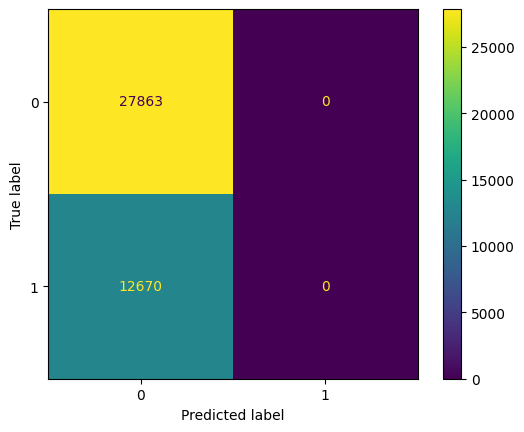

In [17]:
# Make predictions on the train set
y_pred_train = pipeline.predict(X_train)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
cm_train = confusion_matrix(y_train, y_pred_train)

print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"Recall: {recall_train:.2f}")
print(f"\nConfusion Matrix:")
print("\nClassification Report:")
print(classification_report(y_train, y_pred_train))
print(cm_train)

cmd_train = ConfusionMatrixDisplay(cm_train)
cmd_train.plot()

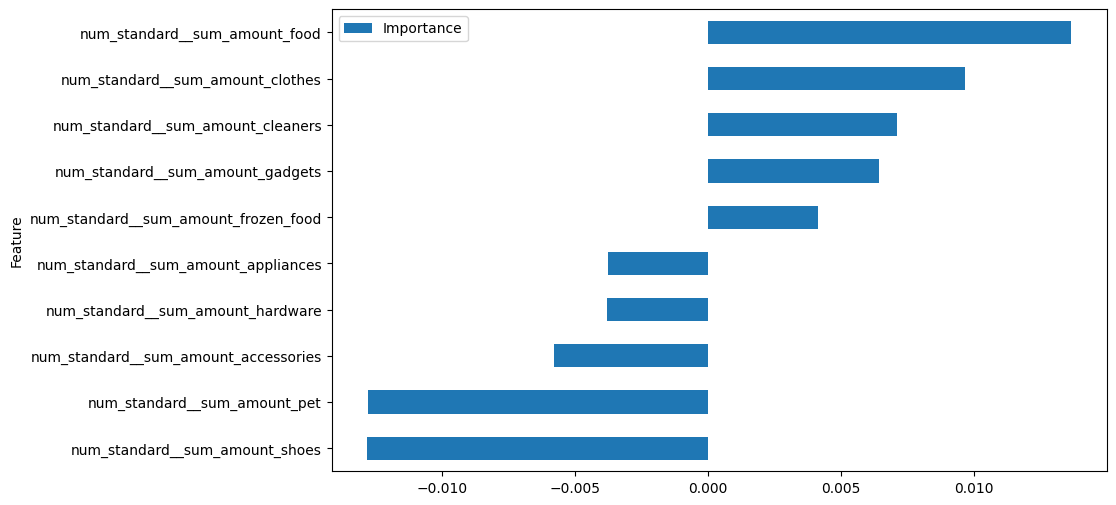

Intercept: -0.7882015726598848


In [18]:
#### Get coefficients & intercept

coefficients = pipeline.named_steps.estimator.coef_[0]
feature_names = pipeline.named_steps.preprocessor.get_feature_names_out()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

intercept = pipeline.named_steps.estimator.intercept_[0]
print(f'Intercept: {intercept}')

In [38]:
# Create modeling ABT (analytics base table)
df_mabt = spark.sql('''
WITH customer_base AS (
    SELECT DISTINCT member_id
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
),
customer_base_joined_with_past_3_months_txn AS (
    SELECT 
        a.member_id,
        b.quantity,
        b.transaction_date
    FROM customer_base AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
),
customer_base_with_aggregated_total_txns_per_month AS (
    SELECT 
        member_id,
        SUM(CASE 
            WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' THEN quantity 
            ELSE 0 
        END) AS sum_quantity,
        '2018-07-01' AS partition_date
    FROM customer_base_joined_with_past_3_months_txn
    GROUP BY member_id
),
customers_with_target_definition AS (
    SELECT 
        a.member_id,
        a.sum_quantity,
        a.partition_date,
        b.age,  
        b.branch_name, 
        CASE 
            WHEN a.sum_quantity = 0 THEN 1 
            ELSE 0 
        END AS target
    FROM customer_base_with_aggregated_total_txns_per_month AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
),
customers_joined_with_features AS (
    SELECT 
        a.member_id,
        b.quantity,
        b.amount,
        b.age,
        b.branch_name,
        b.category_name,
        b.transaction_date
    FROM customers_with_target_definition AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
),
aggregated_categories AS (
    SELECT
       member_id,
       SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name = 'ACCESSORIES' THEN amount ELSE 0 END) AS sum_amount_accessories,
       SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name = 'APPLIANCES' THEN amount ELSE 0 END) AS sum_amount_appliances,
       SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name = 'CLEANERS' THEN amount ELSE 0 END) AS sum_amount_cleaners,
       SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name = 'CLOTHES' THEN amount ELSE 0 END) AS sum_amount_clothes,
       SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name = 'FOOD' THEN amount ELSE 0 END) AS sum_amount_food,
       SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name = 'FROZEN FOOD' THEN amount ELSE 0 END) AS sum_amount_frozen_food,
       SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name = 'GADGETS' THEN amount ELSE 0 END) AS sum_amount_gadgets,
       SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name = 'HARDWARE' THEN amount ELSE 0 END) AS sum_amount_hardware,
       SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name = 'PET' THEN amount ELSE 0 END) AS sum_amount_pet,
       SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name = 'SHOES' THEN amount ELSE 0 END) AS sum_amount_shoes
    FROM customers_joined_with_features
    GROUP BY member_id
),
customers_with_target_joined_with_features AS (
    SELECT 
        a.member_id,
        a.target,
        a.age,
        a.branch_name,
        b.sum_amount_accessories,
        b.sum_amount_appliances,
        b.sum_amount_cleaners,
        b.sum_amount_clothes,
        b.sum_amount_food,
        b.sum_amount_frozen_food,
        b.sum_amount_gadgets,
        b.sum_amount_hardware,
        b.sum_amount_pet,
        b.sum_amount_shoes,
        a.partition_date
    FROM customers_with_target_definition AS a
    LEFT JOIN aggregated_categories AS b
    ON a.member_id = b.member_id
)
SELECT * 
FROM customers_with_target_joined_with_features
''')
df_mabt.createOrReplaceTempView("df_mabt_view")

In [39]:
# Save modeling ABT as pandas
pdf_mabt = df_mabt.toPandas()
pdf_mabt.head()

,member_id,target,age,branch_name,sum_amount_accessories,sum_amount_appliances,sum_amount_cleaners,sum_amount_clothes,sum_amount_food,sum_amount_frozen_food,sum_amount_gadgets,sum_amount_hardware,sum_amount_pet,sum_amount_shoes,partition_date
0,00000867-cfdb-11eb-80ce-d8f2ca37414f,1,50-55,E_Store,50400,0,0,0,0,131600,44800,0,210000,138600,2018-07-01
1,00000867-cfdb-11eb-80ce-d8f2ca37414f,1,50-55,J_Store,50400,0,0,0,0,131600,44800,0,210000,138600,2018-07-01
2,00000867-cfdb-11eb-80ce-d8f2ca37414f,1,50-55,J_Store,50400,0,0,0,0,131600,44800,0,210000,138600,2018-07-01
3,00000867-cfdb-11eb-80ce-d8f2ca37414f,1,50-55,J_Store,50400,0,0,0,0,131600,44800,0,210000,138600,2018-07-01
4,00000867-cfdb-11eb-80ce-d8f2ca37414f,1,50-55,J_Store,50400,0,0,0,0,131600,44800,0,210000,138600,2018-07-01


In [40]:
# Check column names in data
pdf_mabt.columns

Index(['member_id', 'target', 'age', 'branch_name', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'partition_date'],
      dtype='object')

In [41]:
pdf_mabt.groupby(['target'])[[
    'age', 'branch_name', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes'
]].describe().T

target                                   0              1
sum_amount_accessories count  2.233820e+05   55300.000000
                       mean   6.208611e+03    5135.632911
                       std    2.377799e+04   17755.333502
                       min    0.000000e+00       0.000000
                       25%    0.000000e+00       0.000000
                       50%    0.000000e+00       0.000000
                       75%    0.000000e+00       0.000000
                       max    3.765000e+05  200200.000000
sum_amount_appliances  count  2.233820e+05   55300.000000
                       mean   5.507792e+03    4551.441230
                       std    2.136560e+04   16433.883957
                       min    0.000000e+00       0.000000
                       25%    0.000000e+00       0.000000
                       50%    0.000000e+00       0.000000
                       75%    0.000000e+00       0.000000
                       max    3.585000e+05  292500.000000
sum_amount_cleaners    count  2.233820e+05   55300.000000
                       mean   3.512362e+04   30157.777577
                       std    8.441066e+04   69012.149642
                       min    0.000000e+00       0.000000
                       25%    0.000000e+00       0.000000
                       50%    0.000000e+00       0.000000
                       75%    3.840000e+04   32000.000000
                       max    1.164000e+06  830700.000000
sum_amount_clothes     count  2.233820e+05   55300.000000
                       mean   6.213744e+03    5504.891501
                       std    2.382897e+04   18672.996918
                       min    0.000000e+00       0.000000
                       25%    0.000000e+00       0.000000
                       50%    0.000000e+00       0.000000
                       75%    0.000000e+00       0.000000
                       max    3.791000e+05  239400.000000
sum_amount_food        count  2.233820e+05   55300.000000
                       mean   5.580175e+03    5273.813743
                       std    2.228617e+04   18464.951005
                       min    0.000000e+00       0.000000
                       25%    0.000000e+00       0.000000
                       50%    0.000000e+00       0.000000
                       75%    0.000000e+00       0.000000
                       max    3.840000e+05  230400.000000
sum_amount_frozen_food count  2.233820e+05   55300.000000
                       mean   6.398382e+03    5065.151899
                       std    2.420728e+04   18081.981996
                       min    0.000000e+00       0.000000
                       25%    0.000000e+00       0.000000
                       50%    0.000000e+00       0.000000
                       75%    0.000000e+00       0.000000
                       max    4.437000e+05  415200.000000
sum_amount_gadgets     count  2.233820e+05   55300.000000
                       mean   5.639524e+03    5185.775769
                       std    2.199477e+04   18047.328354
                       min    0.000000e+00       0.000000
                       25%    0.000000e+00       0.000000
                       50%    0.000000e+00       0.000000
                       75%    0.000000e+00       0.000000
                       max    4.200000e+05  226800.000000
sum_amount_hardware    count  2.233820e+05   55300.000000
                       mean   5.983148e+03    4784.665461
                       std    2.332093e+04   17311.637907
                       min    0.000000e+00       0.000000
                       25%    0.000000e+00       0.000000
                       50%    0.000000e+00       0.000000
                       75%    0.000000e+00       0.000000
                       max    3.672000e+05  224000.000000
sum_amount_pet         count  2.233820e+05   55300.000000
                       mean   3.315814e+04   27569.641953
                       std    7.693639e+04   59130.279580
                       min    0.000000e+00       0.00000

In [42]:
data = pdf_mabt[['target', 
    'age', 'branch_name', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes'
]].copy()

In [43]:
# Separate target variable and features
from sklearn.model_selection import train_test_split

target_col = 'target'

X = data.loc[:, data.columns != target_col]
y = data.loc[:, target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {X_train.shape[0]} samples')
print(f'Testing set size: {X_test.shape[0]} samples')

Training set size: 222945 samples
Testing set size: 55737 samples


In [44]:
X_train.head()

,age,branch_name,sum_amount_accessories,sum_amount_appliances,sum_amount_cleaners,sum_amount_clothes,sum_amount_food,sum_amount_frozen_food,sum_amount_gadgets,sum_amount_hardware,sum_amount_pet,sum_amount_shoes
231423,55-60,E_Store,0,0,42600,0,0,0,0,0,0,0
158036,18-25,D_Store,0,0,0,0,0,0,0,0,0,0
160702,40-45,G_Store,0,0,0,0,0,0,0,0,10600,0
230258,50-55,I_Store,0,0,0,0,0,0,0,0,0,0
106292,50-55,J_Store,0,0,0,0,0,0,0,0,0,0


In [45]:
y_train.head()

231423    0
158036    0
160702    1
230258    0
106292    0
Name: target, dtype: int32

In [46]:
features = list(X_train.columns)

In [47]:
print(y_train.value_counts())
print(y_test.value_counts())

target
0    178661
1     44284
Name: count, dtype: int64
target
0    44721
1    11016
Name: count, dtype: int64


In [ ]:
from catboost import CatBoostClassifier

X_train = X_train.astype(str)
X_test = X_test.astype(str)

cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=50, eval_metric='F1', early_stopping_rounds=50)

model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), plot=True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0002709	test: 0.0000000	best: 0.0000000 (0)	total: 365ms	remaining: 3m 2s
50:	learn: 0.6171389	test: 0.7065236	best: 0.7065236 (50)	total: 19.5s	remaining: 2m 51s
100:	learn: 0.6403522	test: 0.7299880	best: 0.7299880 (100)	total: 49.1s	remaining: 3m 13s
150:	learn: 0.6466313	test: 0.7352589	best: 0.7352589 (150)	total: 1m 9s	remaining: 2m 40s
200:	learn: 0.6515628	test: 0.7389873	best: 0.7389873 (200)	total: 1m 30s	remaining: 2m 13s
250:	learn: 0.6542359	test: 0.7415425	best: 0.7415425 (250)	total: 1m 50s	remaining: 1m 49s
300:	learn: 0.6569899	test: 0.7424363	best: 0.7426337 (277)	total: 2m 11s	remaining: 1m 26s
350:	learn: 0.6588026	test: 0.7436725	best: 0.7436725 (350)	total: 2m 31s	remaining: 1m 4s
400:	learn: 0.6608876	test: 0.7447097	best: 0.7447097 (399)	total: 2m 52s	remaining: 42.6s
450:	learn: 0.6624597	test: 0.7446941	best: 0.7449361 (443)	total: 3m 13s	remaining: 21s
499:	learn: 0.6634908	test: 0.7453486	best: 0.7453486 (499)	total: 3m 34s	remaining: 0us

bestTe

In [54]:
y_pred = model.predict(X_test)

print(f'Predictions: {y_pred[:50]}')

Predictions: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 0 0]


Accuracy: 0.9192
F1: 0.7453
Precision: 0.9885
Recall: 0.5982

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     44721
           1       0.99      0.60      0.75     11016

    accuracy                           0.92     55737
   macro avg       0.95      0.80      0.85     55737
weighted avg       0.93      0.92      0.91     55737

[[44644    77]
 [ 4426  6590]]


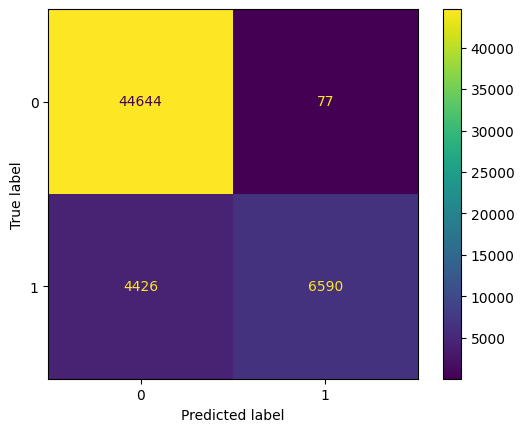

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'F1: {f1_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm_train = confusion_matrix(y_test, y_pred)
print(cm_train)

cmd_train = ConfusionMatrixDisplay(cm_train)
cmd_train.plot()

Analysis of Week 4: Machine Learning Model Engineering

The SQL query constructs the analytical base table (ABT) by first identifying customers who made transactions in July 2018 (`customer_base`). Their past three months of transactions (April–June 2018) are then joined (`customer_base_joined_with_past_3_months_txn`) and aggregated to compute total purchases (`customer_base_with_aggregated_total_txns_per_month`). A **target variable** is defined based on whether a customer made purchases or not (`customers_with_target_definition`). To enrich the dataset, additional customer attributes such as **age, branch_name, quantity, amount, and product categories** are included by joining past transactions from January–March 2018 (`customers_joined_with_features`). The query then aggregates spending across different product categories (i.e., accessories, appliances, food) to capture customer purchasing patterns (`aggregated_categories`). Finally, all features are merged into a structured dataset (`customers_with_target_joined_with_features`), making it ready for model training.

Analysis of Week 5: Machine Learning Model Evaluation

To improve customer churn prediction, **CatBoostClassifier** was used due to its ability to handle categorical features efficiently. The dataset was preprocessed by converting all feature columns to strings and identifying categorical variables using `select_dtypes()`. The model was initialized with **500 iterations**, a **depth of 6**, and a **learning rate of 0.1**, optimizing for **F1-score** to address class imbalance. **Early stopping (50 rounds)** prevented overfitting, and categorical features were explicitly passed to leverage **CatBoost’s ordered boosting**. The model was trained with an evaluation set to monitor performance, and `plot=True` enabled visualization of learning progress. This approach significantly enhanced prediction accuracy by leveraging CatBoost’s native categorical handling and gradient boosting capabilities.

In the first iteration of the model, customer churn prediction relied solely on aggregated purchase categories within a behavioral window. However, this approach resulted in poor classification performance, as indicated by the initial evaluation metrics:  

- **Accuracy**: 0.69  
- **F1-score**: 0.00  
- **Precision & Recall**: 0.00 (suggesting the model failed to identify churned customers effectively)  

To improve predictive accuracy, the model was enhanced by incorporating additional customer demographic features, specifically **age range** and **most frequented branch**. These refinements led to a significant performance boost:  

- **Accuracy**: 0.9192  
- **F1-score**: 0.7453  
- **Precision**: 0.9885  
- **Recall**: 0.5982  